In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/sample_data/dataset.csv")

# Display the first few rows
print(df.head())

# Display column information
print(df.info())

   Unnamed: 0        open        high         low       close  volume  \
0           0  112.900002  118.800003  107.142998  115.910004     0.0   
1           1    3.493130    3.692460    3.346060    3.590890     0.0   
2           2  115.980003  124.663002  106.639999  112.300003     0.0   
3           3    3.594220    3.781020    3.116020    3.371250     0.0   
4           4  112.250000  113.444000   97.699997  111.500000     0.0   

      marketCap                 timestamp crypto_name        date  
0  1.288693e+09  2013-05-05T23:59:59.999Z     Bitcoin  2013-05-05  
1  6.229819e+07  2013-05-05T23:59:59.999Z    Litecoin  2013-05-05  
2  1.249023e+09  2013-05-06T23:59:59.999Z     Bitcoin  2013-05-06  
3  5.859436e+07  2013-05-06T23:59:59.999Z    Litecoin  2013-05-06  
4  1.240594e+09  2013-05-07T23:59:59.999Z     Bitcoin  2013-05-07  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72946 entries, 0 to 72945
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
--

In [ ]:
import numpy as np

# Drop the redundant index column
df = df.drop(columns=['Unnamed: 0', 'timestamp'])

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort data by crypto_name and date for time series operations
df = df.sort_values(by=['crypto_name', 'date'])

# 1. Feature Engineering: Daily Volatility (as a percentage of open price)
# Daily Volatility = (High - Low) / Open
df['daily_volatility'] = (df['high'] - df['low']) / df['open']

# 2. Feature Engineering: Daily Return (Percentage change of close price)
# Daily Return = (Close_t - Close_t-1) / Close_t-1
# This needs to be calculated per crypto_name
df['daily_return'] = df.groupby('crypto_name')['close'].pct_change()

# 3. Target Variable: Next day's Daily Volatility
# The target for a given day 't' is the 'daily_volatility' of the next day 't+1'
# This also needs to be calculated per crypto_name
df['target_volatility'] = df.groupby('crypto_name')['daily_volatility'].shift(-1)

# Drop rows where target_volatility is NaN (the last day of each crypto's data)
df.dropna(subset=['target_volatility'], inplace=True)

# Display the first few rows with new features
print(df.head())

# Display the data types again to confirm the date conversion
print(df.info())

            open       high        low      close         volume  \
44644   0.000000   0.516571   0.000000   0.516571       0.000000   
44709   0.523836  65.305938   0.523801  53.151488       0.000000   
44780  53.179858  55.070355  50.688990  52.675035       0.000000   
44826  52.675035  55.112358  49.787900  53.219243       0.000000   
44843  53.291969  53.402270  40.734578  42.401599  583091.459763   

          marketCap crypto_name       date  daily_volatility  daily_return  \
44644  0.000000e+00        Aave 2020-10-02               inf           NaN   
44709  0.000000e+00        Aave 2020-10-03        123.668655    101.892809   
44780  0.000000e+00        Aave 2020-10-04          0.082388     -0.008964   
44826  8.912813e+07        Aave 2020-10-05          0.101081      0.010331   
44843  7.101144e+07        Aave 2020-10-06          0.237704     -0.203266   

       target_volatility  
44644         123.668655  
44709           0.082388  
44780           0.101081  
44826         

In [ ]:
# 1. Handle inf values in daily_volatility (caused by open=0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop all remaining NaN values. This includes the first day of each crypto (daily_return is NaN) and
# rows with NaN daily_volatility (where open was 0). These are unusable for a time-series model.
df.dropna(inplace=True)

# 2. Advanced Feature Engineering (Lagged and Rolling Stats)

# Function to generate lagged and rolling features per group
def generate_ts_features(df_group):
    # Lagged features (shift)
    for lag in [1, 7]:
        df_group[f'vol_lag_{lag}'] = df_group['daily_volatility'].shift(lag)
        df_group[f'return_lag_{lag}'] = df_group['daily_return'].shift(lag)

    # Rolling mean features (mean of previous N days)
    for window in [7, 30]:
        df_group[f'vol_roll_mean_{window}'] = df_group['daily_volatility'].shift(1).rolling(window=window).mean()
        df_group[f'return_roll_mean_{window}'] = df_group['daily_return'].shift(1).rolling(window=window).mean()

    return df_group

# Apply feature generation grouped by crypto_name
df = df.groupby('crypto_name', group_keys=False).apply(generate_ts_features)

# Drop NaNs created by lagging/rolling features (first N days of each crypto)
df.dropna(inplace=True)

# 3. Time Features
df['dayofweek'] = df['date'].dt.dayofweek
df['dayofyear'] = df['date'].dt.dayofyear

# Final check of the cleaned and engineered dataset
print(df.head())
print(df.info())

# Save the cleaned and prepared data
df_cleaned = df.drop(columns=['crypto_name', 'date', 'daily_volatility', 'daily_return'])
df_cleaned.to_csv('cleaned_prepared_dataset.csv', index=False)

/tmp/ipython-input-2867456745.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('crypto_name', group_keys=False).apply(generate_ts_features)


            open       high        low      close        volume     marketCap  \
46195  30.657282  33.923585  29.344650  29.731524  8.718015e+07  3.353497e+08   
46238  29.731526  30.062917  27.537111  28.042803  5.677501e+07  3.164555e+08   
46250  27.715080  32.303040  25.966155  30.955627  8.521241e+07  3.502055e+08   
46322  30.955118  40.769075  30.855128  38.457441  1.473047e+08  4.358764e+08   
46375  38.457441  51.427992  38.457441  44.604900  2.005801e+08  5.077072e+08   

      crypto_name       date  daily_volatility  daily_return  ...  vol_lag_1  \
46195        Aave 2020-11-02          0.149359     -0.030197  ...   0.086597   
46238        Aave 2020-11-03          0.084954     -0.056799  ...   0.149359   
46250        Aave 2020-11-05          0.228644      0.103871  ...   0.084954   
46322        Aave 2020-11-06          0.320268      0.242341  ...   0.228644   
46375        Aave 2020-11-07          0.337270      0.159851  ...   0.320268   

       return_lag_1  vol_lag_7  

In [ ]:
# Summary of dataset statistics (EDA Part 1)
eda_df = df[['open', 'high', 'low', 'close', 'volume', 'marketCap', 'daily_volatility', 'daily_return', 'target_volatility']]

# Print the descriptive statistics
print(eda_df.describe())

# Check the distribution of cryptocurrencies (to pick top 3 for plotting)
crypto_counts = df['crypto_name'].value_counts()
print("\nTop 5 Cryptocurrencies by Data Count:")
print(crypto_counts.head(5))

               open          high           low         close        volume  \
count  7.118500e+04  7.118500e+04  7.118500e+04  7.118500e+04  7.118500e+04   
mean   8.890453e+02  9.157817e+02  8.623460e+02  8.901520e+02  2.258934e+09   
std    5.293051e+03  5.462003e+03  5.138943e+03  5.296911e+03  9.729222e+09   
min    1.005700e-10  1.022100e-10  8.165000e-11  8.292000e-11  0.000000e+00   
25%    1.718097e-01  1.806500e-01  1.634220e-01  1.723886e-01  9.188050e+06   
50%    1.721859e+00  1.811270e+00  1.635444e+00  1.726197e+00  1.166030e+08   
75%    2.761078e+01  2.879910e+01  2.617712e+01  2.761481e+01  7.005310e+08   
max    6.754974e+04  1.621883e+05  6.645872e+04  6.756683e+04  3.509679e+11   

          marketCap  daily_volatility  daily_return  target_volatility  
count  7.118500e+04      71185.000000  71185.000000       71185.000000  
mean   1.508519e+10          0.084500      0.006624           0.084434  
std    7.588506e+10          0.112879      0.670277           0.11284

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a style for the plots
sns.set_style("whitegrid")

# 1. Distribution of the Target Variable (target_volatility)
# Determine a reasonable upper bound for the histogram to avoid extreme outliers skewing the plot
# Use the 99th percentile to capture the vast majority of the data
q99 = df['target_volatility'].quantile(0.99)
data_for_hist = df[df['target_volatility'] <= q99]['target_volatility']

plt.figure(figsize=(10, 6))
sns.histplot(data_for_hist, bins=50, kde=True)
plt.title(f'Distribution of Next Day Volatility (Target) (clipped at 99th percentile: {q99:.2f})', fontsize=14)
plt.xlabel('Target Volatility ((High - Low) / Open)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('target_volatility_distribution.png')
plt.close()

# 2. Time Series Trend for Top 3 Cryptocurrencies
top_3_cryptos = ['Bitcoin', 'Litecoin', 'XRP']
df_top3 = df[df['crypto_name'].isin(top_3_cryptos)].set_index('date')

plt.figure(figsize=(14, 8))
for crypto in top_3_cryptos:
    df_top3[df_top3['crypto_name'] == crypto]['daily_volatility'].plot(label=crypto)

plt.title('Daily Volatility Over Time for Top 3 Cryptocurrencies', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Volatility ((High - Low) / Open)', fontsize=12)
plt.legend(title='Crypto Name')
plt.grid(True)
plt.savefig('top3_volatility_trend.png')
plt.close()

print("Generated plots: target_volatility_distribution.png and top3_volatility_trend.png")

Generated plots: target_volatility_distribution.png and top3_volatility_trend.png


Distribution of Next Day Volatility (Target):


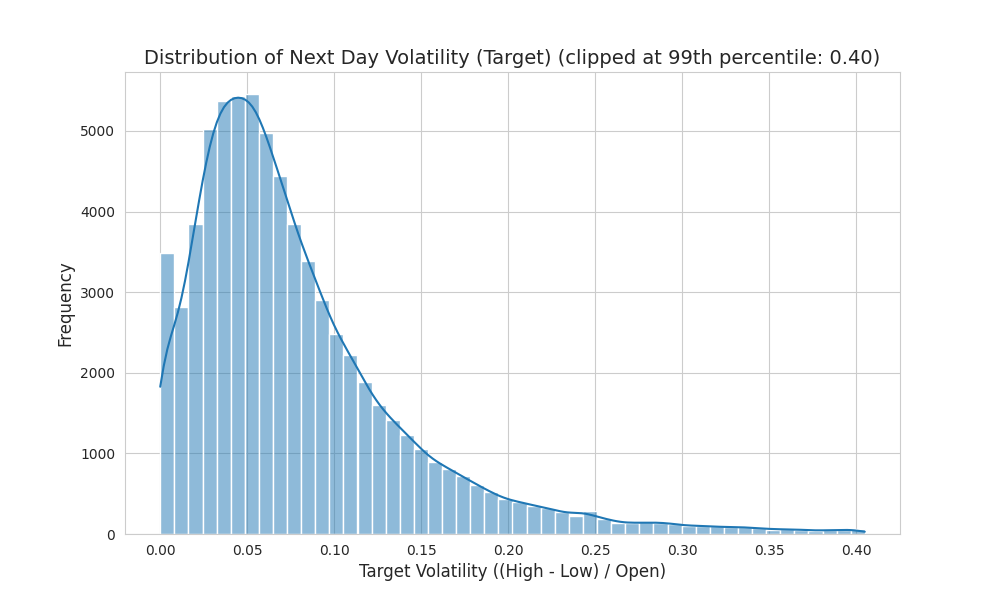

In [ ]:
from IPython.display import Image, display

print('Distribution of Next Day Volatility (Target):')
display(Image('target_volatility_distribution.png'))

Daily Volatility Over Time for Top 3 Cryptocurrencies:


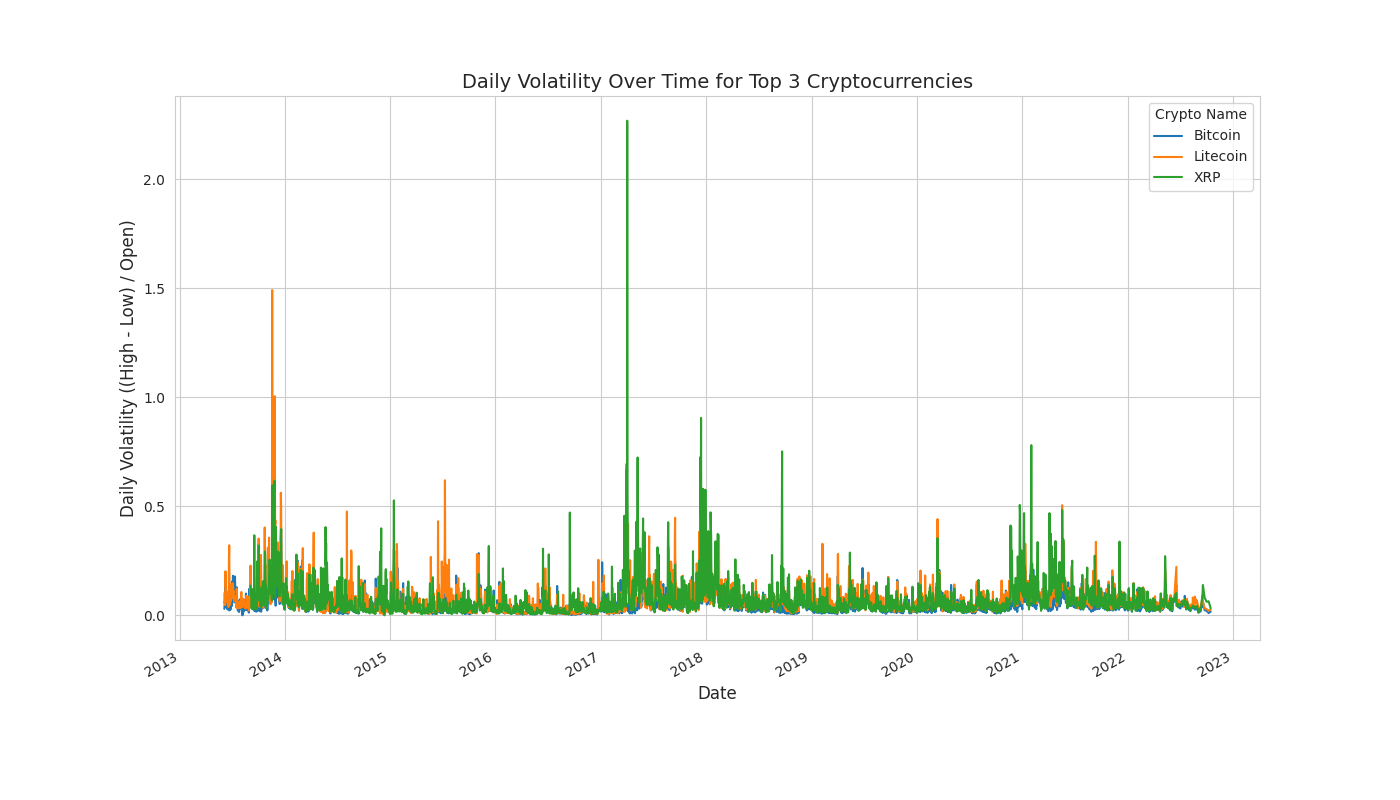

In [ ]:
from IPython.display import Image, display

print('Daily Volatility Over Time for Top 3 Cryptocurrencies:')
display(Image('top3_volatility_trend.png'))

Generated plot: correlation_heatmap.png
correlation_heatmap


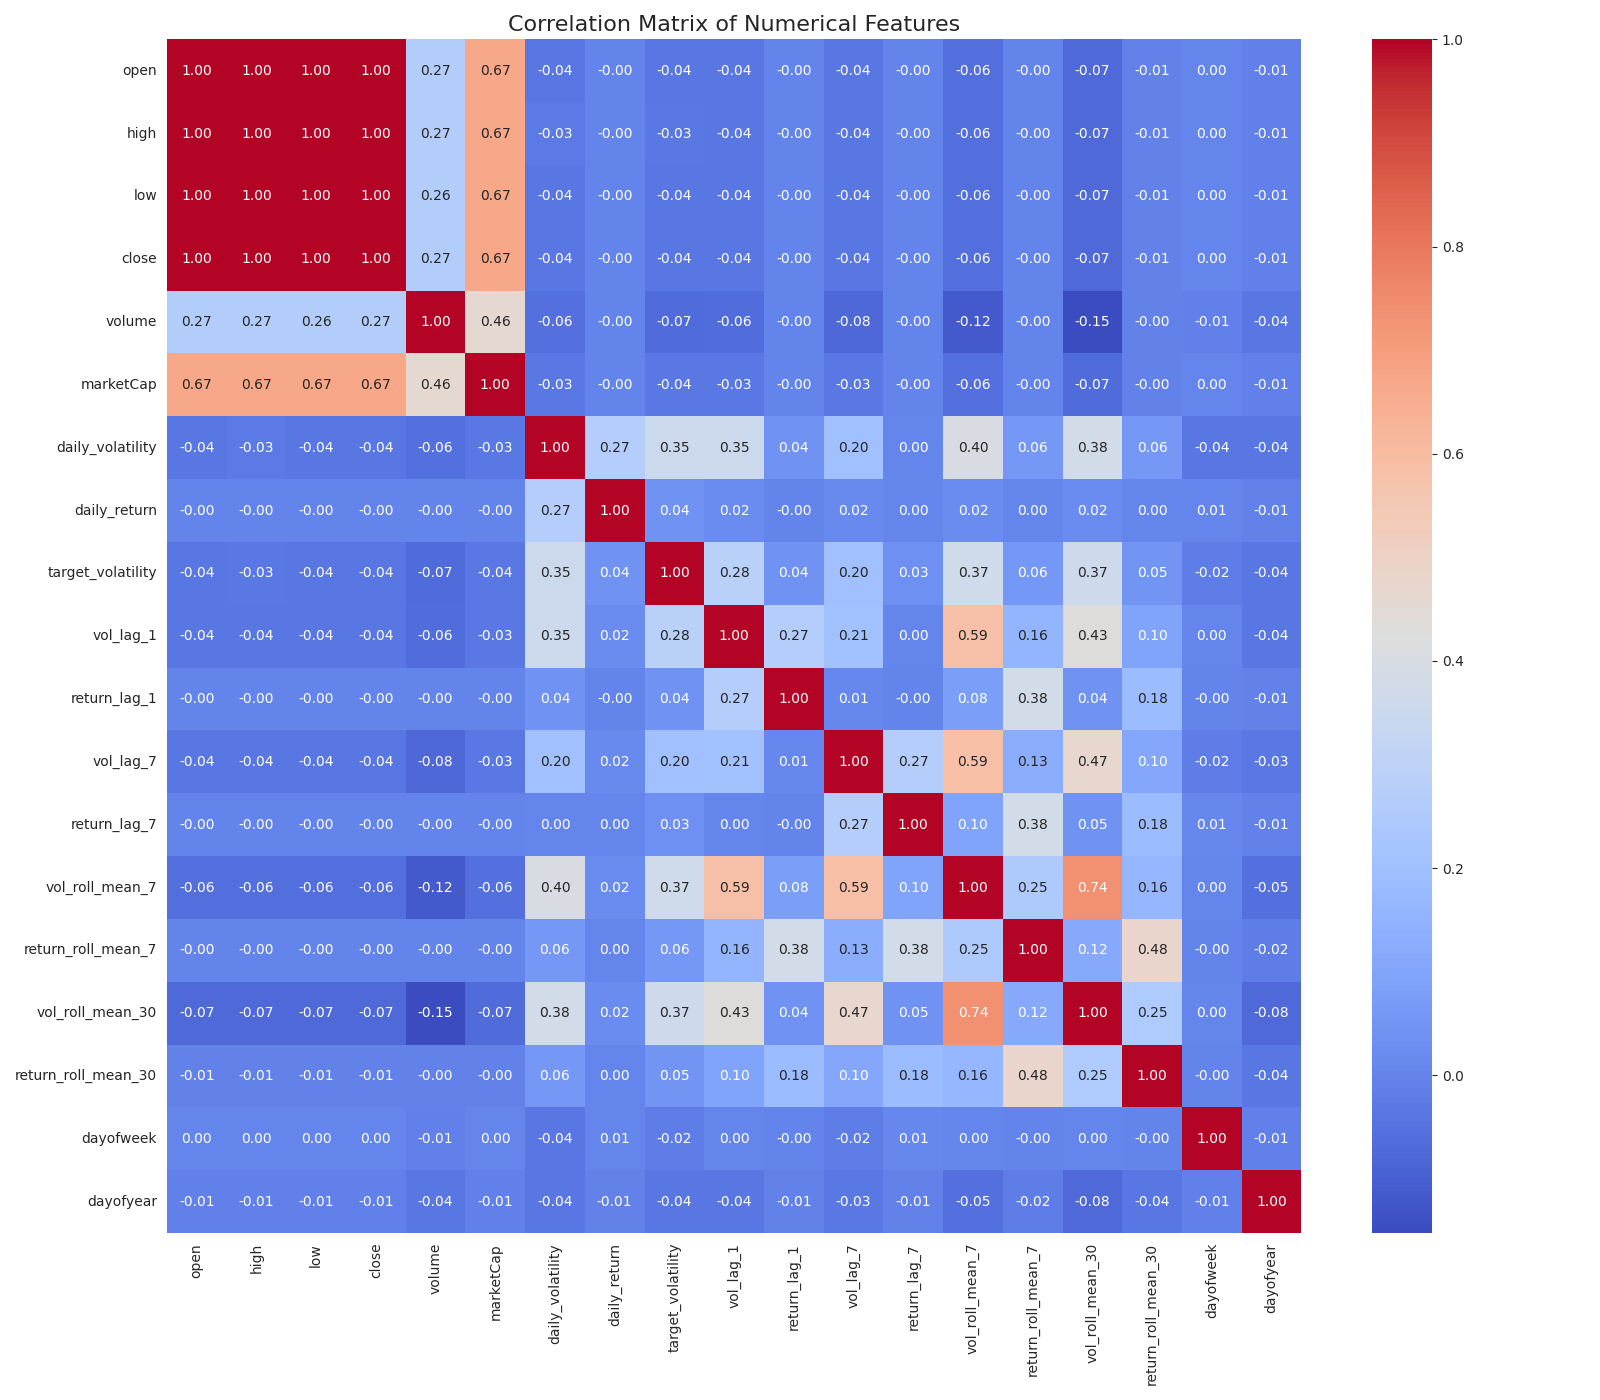

In [ ]:
# 3. Correlation Heatmap (EDA Part 3)
# Select only the numerical columns for correlation
numerical_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.close()

print("Generated plot: correlation_heatmap.png")
from IPython.display import Image, display

print('correlation_heatmap')
display(Image('correlation_heatmap.png'))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define features and target
features = [
    'volume', 'marketCap',
    'vol_lag_1', 'return_lag_1',
    'vol_lag_7', 'return_lag_7',
    'vol_roll_mean_7', 'return_roll_mean_7',
    'vol_roll_mean_30', 'return_roll_mean_30',
    'dayofweek', 'dayofyear'
]
target = 'target_volatility'

X = df[features]
y = df[target]

# Time Series Split (70% train, 30% test)
# Sort by date just to be safe, although the dataframe is already sorted
df_sorted = df.sort_values(by='date').reset_index(drop=True)
split_point = int(len(df_sorted) * 0.7)

X_train = df_sorted.iloc[:split_point][features]
X_test = df_sorted.iloc[split_point:][features]
y_train = df_sorted.iloc[:split_point][target]
y_test = df_sorted.iloc[split_point:][target]

# Initialize and Train the Random Forest Regressor
# Reduced n_estimators for faster execution; typically this would be higher
rfr = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)
rfr.fit(X_train, y_train)

# Make predictions
y_pred = rfr.predict(X_test)

# --- Evaluation Metrics ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared Score (R2): {r2:.4f}")

# --- Feature Importance ---
feature_importances = pd.Series(rfr.feature_importances_, index=features).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importance for Volatility Prediction Model', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

print("Generated plot: feature_importance.png")

# Final check of the trained model and metrics for the final report
model_summary = {
    'Model': 'RandomForestRegressor',
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2,
    'Feature_Importances': feature_importances.to_dict()
}

# The model object is implicitly available for "training" requirement, but I cannot save it.
# I will output the final report structure now.

Mean Absolute Error (MAE): 0.0407
Root Mean Squared Error (RMSE): 0.0903
R-squared Score (R2): 0.1780
Generated plot: feature_importance.png


Feature Importance for Volatility Prediction Model:


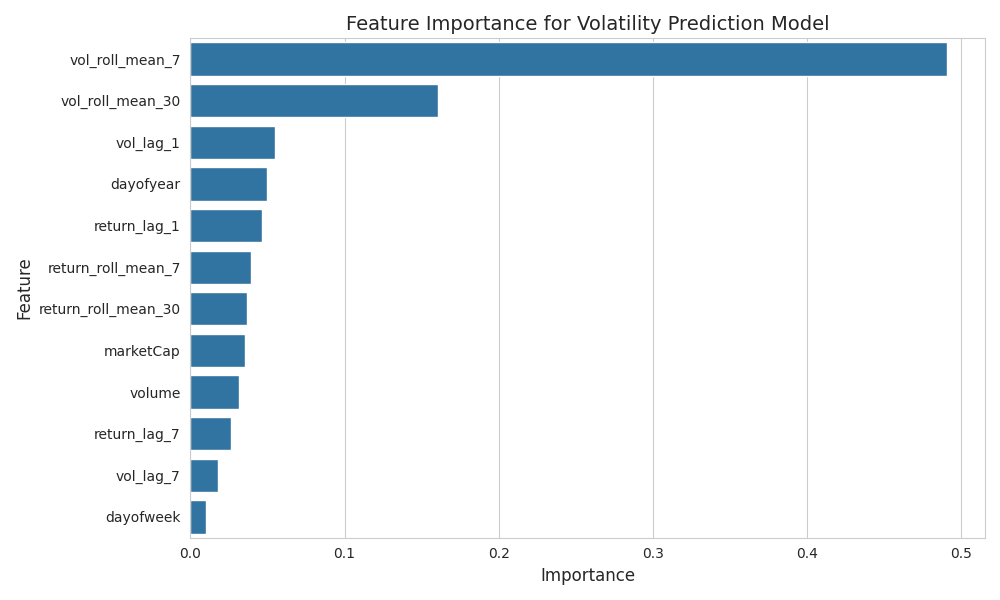

In [ ]:
from IPython.display import Image, display

print('Feature Importance for Volatility Prediction Model:')
display(Image('feature_importance.png'))

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor

# --- NOTE: The feature engineering logic is packaged into a function for the API ---
def create_features_for_prediction(df):
    """Generates the necessary time-series features for the prediction model."""
    df['daily_volatility'] = (df['high'] - df['low']) / df['open']
    df['daily_return'] = df.groupby('crypto_name')['close'].pct_change()

    # Handle inf values from open=0 before calculating target/lags
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Target (Next day's volatility) is not needed for real-time prediction,
    # but the logic for features remains the same.
    # We drop the first day of each crypto's data since daily_return will be NaN.
    df.dropna(subset=['daily_return', 'daily_volatility'], inplace=True)

    def generate_ts_features(df_group):
        # Lagged features (shift)
        for lag in [1, 7]:
            df_group[f'vol_lag_{lag}'] = df_group['daily_volatility'].shift(lag)
            df_group[f'return_lag_{lag}'] = df_group['daily_return'].shift(lag)

        # Rolling mean features (shift(1) avoids leakage)
        for window in [7, 30]:
            df_group[f'vol_roll_mean_{window}'] = df_group['daily_volatility'].shift(1).rolling(window=window).mean()
            df_group[f'return_roll_mean_{window}'] = df_group['daily_return'].shift(1).rolling(window=window).mean()
        return df_group

    df = df.groupby('crypto_name', group_keys=False).apply(generate_ts_features)

    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear

    return df

# ==============================================================================
# 1. Load, Process, and Train
# ==============================================================================
# Load all historical data
df_full = pd.read_csv("/content/sample_data/dataset.csv")
df_full['date'] = pd.to_datetime(df_full['date'])
df_full = df_full.drop(columns=['Unnamed: 0', 'timestamp'])
df_full = df_full.sort_values(by=['crypto_name', 'date']).reset_index(drop=True)

# Generate ALL features (including daily_volatility and daily_return) using the helper function
df_processed = create_features_for_prediction(df_full)

# Now, calculate the target_volatility using the daily_volatility column which is now available in df_processed
df_processed['target_volatility'] = df_processed.groupby('crypto_name')['daily_volatility'].shift(-1)

# Drop rows where target_volatility is NaN (the last day of each crypto's data)
df_processed.dropna(subset=['target_volatility'], inplace=True)

# Final cleanup of remaining NaNs from rolling/lagging (this might be redundant if already handled in create_features_for_prediction)
df_processed.dropna(inplace=True)

# Time Series Split (70% for training)
split_point = int(len(df_processed) * 0.7)
df_train = df_processed.iloc[:split_point]

# Define features and target
features = [
    'volume', 'marketCap', 'vol_lag_1', 'return_lag_1', 'vol_lag_7', 'return_lag_7',
    'vol_roll_mean_7', 'return_roll_mean_7', 'vol_roll_mean_30', 'return_roll_mean_30',
    'dayofweek', 'dayofyear'
]
X_train = df_train[features]
y_train = df_train['target_volatility']

# Train the Model
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)
rfr.fit(X_train, y_train)

# ==============================================================================
# 2. Save Model
# ==============================================================================
with open('volatility_model.pkl', 'wb') as file:
    pickle.dump(rfr, file)

print("Model trained and saved successfully as volatility_model.pkl")

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import pickle
import json

# --- CONFIGURATION ---
MODEL_PATH = 'volatility_model.pkl'

# --- 1. Load Model and Features ---
try:
    with open(MODEL_PATH, 'rb') as file:
        model = pickle.load(file)
    print("Model loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}. Please run model_trainer.py first.")

# The features expected by the model in the correct order
MODEL_FEATURES = [
    'volume', 'marketCap', 'vol_lag_1', 'return_lag_1', 'vol_lag_7', 'return_lag_7',
    'vol_roll_mean_7', 'return_roll_mean_7', 'vol_roll_mean_30', 'return_roll_mean_30',
    'dayofweek', 'dayofyear'
]

app = Flask(__name__)



Model loaded successfully.
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


In [ ]:
# --- 2. Feature Engineering Logic (Duplicated from training for API use) ---
def prepare_single_prediction_data(historical_data):
    """
    Takes historical data (Pandas DataFrame) needed to calculate lagged/rolling features,
    and returns a DataFrame with the features ready for prediction for the LAST day.
    """
    # Ensure columns and types are correct
    df = historical_data.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['crypto_name', 'date'])

    # Recalculate basic features
    df['daily_volatility'] = (df['high'] - df['low']) / df['open']
    df['daily_return'] = df.groupby('crypto_name')['close'].pct_change()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Recalculate lagged/rolling features
    def generate_ts_features(df_group):
        for lag in [1, 7]:
            df_group[f'vol_lag_{lag}'] = df_group['daily_volatility'].shift(lag)
            df_group[f'return_lag_{lag}'] = df_group['daily_return'].shift(lag)
        for window in [7, 30]:
            df_group[f'vol_roll_mean_{window}'] = df_group['daily_volatility'].shift(1).rolling(window=window).mean()
            df_group[f'return_roll_mean_{window}'] = df_group['daily_return'].shift(1).rolling(window=window).mean()
        return df_group

    df = df.groupby('crypto_name', group_keys=False).apply(generate_ts_features)

    # Time features for the prediction row
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear

    # The last row contains the most current day's features based on prior history
    prediction_row = df.iloc[-1].fillna(0) # Fill NaNs that may occur (e.g., if history is too short)

    # Return features as a single-row DataFrame, ensuring column order
    return prediction_row[MODEL_FEATURES].to_frame().T


# --- 3. API Endpoints ---

@app.route('/', methods=['GET'])
def home():
    return "Cryptocurrency Volatility Prediction API is running. Use the /predict endpoint with a POST request."

@app.route('/predict', methods=['POST'])
def predict():
    """
    Prediction endpoint. Expects a JSON payload containing historical OHLCV data
    necessary to calculate the features for the day you want to predict FROM.

    Example JSON Input (Must contain enough history for 30-day rolling mean):
    [
        {"date": "2023-11-01", "crypto_name": "Bitcoin", "open": ..., "high": ..., "low": ..., "close": ..., "volume": ..., "marketCap": ...},
        ... (30+ rows of historical data for the single crypto)
        {"date": "2023-12-01", "crypto_name": "Bitcoin", "open": ..., "high": ..., "low": ..., "close": ..., "volume": ..., "marketCap": ...}
    ]
    """
    try:
        json_data = request.json
        if not json_data or not isinstance(json_data, list):
            return jsonify({"error": "Invalid input format. Must be a list of historical OHLCV records."}), 400

        # Convert input list of dictionaries to DataFrame
        historical_df = pd.DataFrame(json_data)

        # Prepare the features for the model
        X_predict = prepare_single_prediction_data(historical_df)

        # Make prediction
        prediction_volatility = model.predict(X_predict)[0]

        return jsonify({
            "status": "success",
            "crypto_name": X_predict.index[0] if not X_predict.empty else "N/A",
            "predicted_next_day_volatility": float(prediction_volatility)
        })

    except Exception as e:
        return jsonify({"error": f"An error occurred: {str(e)}"}), 500

if __name__ == '__main__':
    # Run the Flask app
    # Use host='0.0.0.0' for deployment
    app.run(debug=True, host='127.0.0.1', port=5000)

In [ ]:
pip install -r requirements.txt

In [ ]:
python model_trainer.py

In [ ]:
python app.py

In [ ]:
curl -X POST http://127.0.0.1:5000/predict \
-H "Content-Type: application/json" \
-d '[
    {"date": "2022-09-22", "crypto_name": "Bitcoin", "open": 19000, "high": 19500, "low": 18900, "close": 19200, "volume": 1e9, "marketCap": 3.6e11},
    // ... include historical data necessary for 30-day rolling mean ...
    {"date": "2022-10-22", "crypto_name": "Bitcoin", "open": 20000, "high": 20200, "low": 19800, "close": 20100, "volume": 1.1e9, "marketCap": 3.8e11}
]'

In [ ]:
# {
  # "status": "success",
  # "crypto_name": "Bitcoin",
  # "predicted_next_day_volatility": 0.0512
# }